In [1]:
import os
import torch
from numpy import dtype
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

data_dir = 'C:/Users/avp/OneDrive - HKUST Connect/Desktop/Deep T-Rex/Code/Python/Deep T-Rex/Deep T-Rex/data'

# A. Generate Data

In [2]:
#!Rscript generate_data.R --N_data=10000

# B. Train Model

In [3]:
class PhiThreshDataset(Dataset):
    def __init__(self, data_dir):
        self.phi_dir = os.path.join(data_dir, 'Phi_mat')
        self.beta_dir = os.path.join(data_dir, 'beta')
        self.v_dir = os.path.join(data_dir, 'v')
        self.FDR_dir = os.path.join(data_dir, 'FDR')
        
        self.phi_files = [f for f in os.listdir(self.phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
        self.beta_files = [f for f in os.listdir(self.beta_dir) if f.startswith('beta_') and f.endswith('.txt')]
        self.v_files = [f for f in os.listdir(self.v_dir) if f.startswith('v_') and f.endswith('.txt')]
        self.FDR_files = [f for f in os.listdir(self.FDR_dir) if f.startswith('FDR_') and f.endswith('.txt')]

    def __len__(self):
        return len(self.phi_files)

    def __getitem__(self, idx):
        phi_file = os.path.join(self.phi_dir, self.phi_files[idx])
        phi = np.loadtxt(phi_file)

        beta_file = os.path.join(self.beta_dir, self.beta_files[idx])
        beta = np.loadtxt(beta_file)
        
        v_file = os.path.join(self.v_dir, self.v_files[idx])
        v = np.loadtxt(v_file)
        
        FDR_file = os.path.join(self.FDR_dir, self.FDR_files[idx])
        FDR = np.loadtxt(FDR_file)

        return torch.tensor(phi, dtype=torch.float32), torch.tensor(beta, dtype=torch.float32), torch.tensor(v, dtype=torch.float32), torch.tensor(FDR, dtype=torch.float32)

In [4]:
def get_data_loaders(data_dir, batch_size=32, test_size=0.2):
    dataset = PhiThreshDataset(data_dir)
    train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=42)
    
    train_set = torch.utils.data.Subset(dataset, train_indices)
    test_set = torch.utils.data.Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_indices, test_indices

In [5]:
class PhiNet(nn.Module):
    def __init__(self, input_size):
        super(PhiNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, Phi, v):
        x = torch.cat((Phi, v.unsqueeze(1)), dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [6]:
def sigma_v(x, v, exponent=10):
    v = v.view(-1, 1)
    return 1 / (1 + torch.exp(-exponent * (x - v)))

def FDR_surr(v, Phi, beta):
    return torch.sum(sigma_v((1 - beta) * Phi, v), dim=1) / torch.sum(sigma_v(Phi, v), dim=1)

In [7]:
def evaluate_model(model, train_loader, test_loader, criterion, verbose=True, device=device):
    model.eval()
    losses_over_train = []
    with torch.no_grad():
        for Phis, betas, vs, FDRs in train_loader:
            Phis, betas, vs, FDRs = Phis.to(device), betas.to(device), vs.to(device), FDRs.to(device)
            outputs = model(Phis, vs)
            loss = criterion(outputs, FDRs)
            losses_over_train.append(loss.item())
    if verbose:
        print(f'Train Loss: {sum(losses_over_train) / len(train_loader):.4f}')
    
    losses_over_test = []
    with torch.no_grad():
        for Phis, betas, vs, FDRs in test_loader:
            Phis, betas, vs, FDRs = Phis.to(device), betas.to(device), vs.to(device), FDRs.to(device)
            outputs = model(Phis, vs)
            loss = criterion(outputs, FDRs)
            losses_over_test.append(loss.item())
    if verbose:
        print(f'Test Loss: {sum(losses_over_test) / len(test_loader):.4f}')
    
    return losses_over_train, losses_over_test

def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device=device):
    model.train()
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", position=0)
        for _, (Phis, betas, vs, FDRs) in progress_bar:
            Phis, betas, vs, FDRs = Phis.to(device), betas.to(device), vs.to(device), FDRs.to(device)
            optimizer.zero_grad()
            outputs = model(Phis, vs)
            loss = criterion(outputs, FDRs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Running Loss: {running_loss / len(train_loader):.4f}')
        losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion)
        train_losses.append(sum(losses_over_train) / len(train_loader))
        test_losses.append(sum(losses_over_test) / len(test_loader))
    return train_losses, test_losses

In [8]:
input_size = len(np.loadtxt(os.path.join(data_dir, 'Phi_mat/Phi_mat_1.txt'))) + 1

hparams = {"batch_size": 16,
           "learning_rate": 0.001,
           "num_epochs": 10}

train_loader, test_loader, train_indices, test_indices = get_data_loaders(data_dir, batch_size=hparams["batch_size"])

model = PhiNet(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=hparams["learning_rate"])

train_losses, test_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=hparams["num_epochs"], device=device)

Epoch 1/10:   0%|          | 0/26 [00:00<?, ?it/s]C:\Users\avp\OneDrive - HKUST Connect\Desktop\Deep T-Rex\Code\Python\Deep T-Rex\Deep T-Rex\.venv\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/10:  69%|██████▉   | 18/26 [00:00<00:00, 89.02it/s]C:\Users\avp\OneDrive - HKUST Connect\Desktop\Deep T-Rex\Code\Python\Deep T-Rex\Deep T-Rex\.venv\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/10: 100%|██████████| 26/26 [00:00<00:00, 93.2

Epoch [1/10], Running Loss: 0.0408


C:\Users\avp\OneDrive - HKUST Connect\Desktop\Deep T-Rex\Code\Python\Deep T-Rex\Deep T-Rex\.venv\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Loss: 0.0356
Test Loss: 0.0414


Epoch 2/10: 100%|██████████| 26/26 [00:00<00:00, 111.88it/s]


Epoch [2/10], Running Loss: 0.0317
Train Loss: 0.0286
Test Loss: 0.0298


Epoch 3/10: 100%|██████████| 26/26 [00:00<00:00, 113.51it/s]


Epoch [3/10], Running Loss: 0.0278
Train Loss: 0.0278
Test Loss: 0.0284


Epoch 4/10: 100%|██████████| 26/26 [00:00<00:00, 120.82it/s]


Epoch [4/10], Running Loss: 0.0277
Train Loss: 0.0282
Test Loss: 0.0286


Epoch 5/10: 100%|██████████| 26/26 [00:00<00:00, 116.63it/s]


Epoch [5/10], Running Loss: 0.0277
Train Loss: 0.0277
Test Loss: 0.0287


Epoch 6/10: 100%|██████████| 26/26 [00:00<00:00, 115.36it/s]


Epoch [6/10], Running Loss: 0.0279
Train Loss: 0.0275
Test Loss: 0.0285


Epoch 7/10: 100%|██████████| 26/26 [00:00<00:00, 118.81it/s]


Epoch [7/10], Running Loss: 0.0282
Train Loss: 0.0278
Test Loss: 0.0285


Epoch 8/10: 100%|██████████| 26/26 [00:00<00:00, 119.16it/s]


Epoch [8/10], Running Loss: 0.0276
Train Loss: 0.0276
Test Loss: 0.0286


Epoch 9/10: 100%|██████████| 26/26 [00:00<00:00, 119.27it/s]


Epoch [9/10], Running Loss: 0.0275
Train Loss: 0.0279
Test Loss: 0.0286


Epoch 10/10: 100%|██████████| 26/26 [00:00<00:00, 115.29it/s]


Epoch [10/10], Running Loss: 0.0282
Train Loss: 0.0277
Test Loss: 0.0283


# Evaluate Model

In [9]:
losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion, device=device)

Train Loss: 0.0274
Test Loss: 0.0283


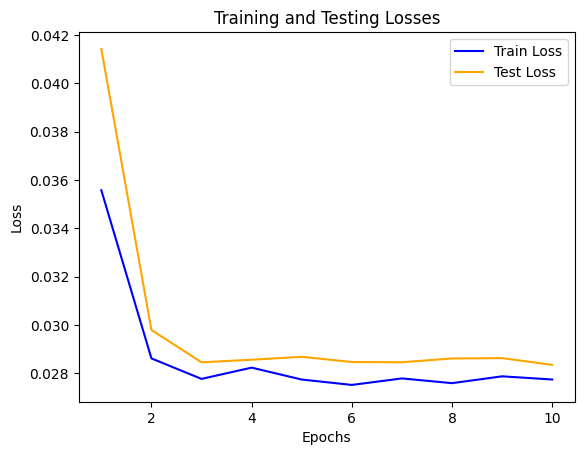

In [10]:
epochs = range(1, len(train_losses) + 1)

# Plot both training and testing losses
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, test_losses, label='Test Loss', color='orange')

# Adding titles and labels
plt.title('Training and Testing Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
    
# Show the plot
plt.show()

## FDR distribution

### Training Data

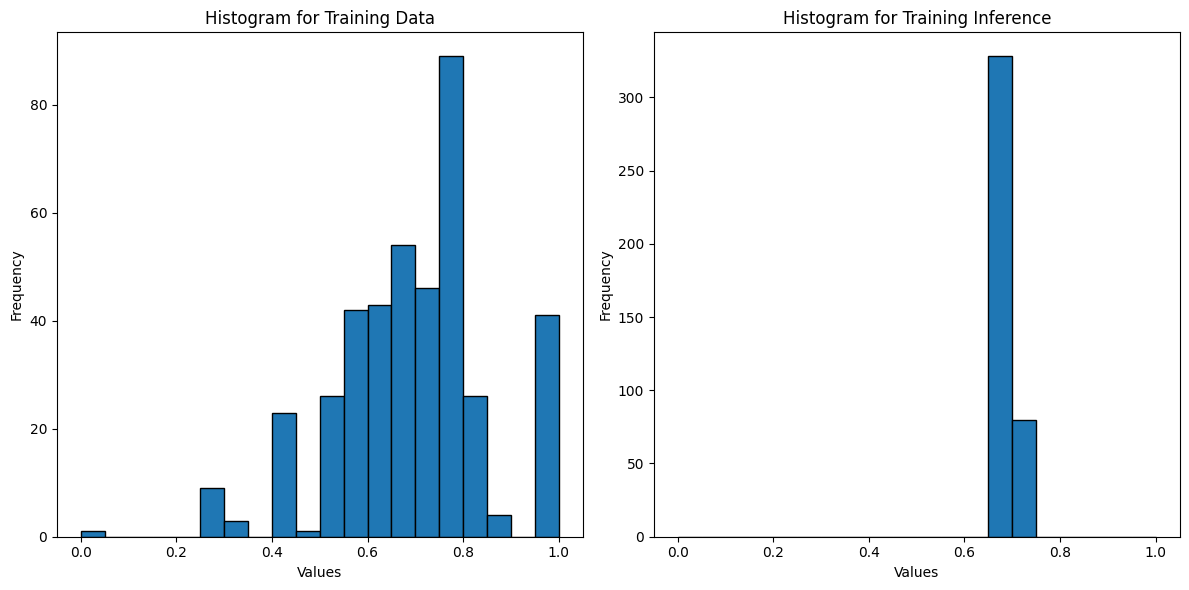

In [11]:
model.eval()

with torch.no_grad():
    train_loader_v = []
    train_infer_v = []
    for Phis, betas, vs, FDRs in train_loader:
        Phis, betas, vs, FDRs = Phis.to(device), betas.to(device), vs.to(device), FDRs.to(device)
        train_loader_v += FDRs.cpu().numpy().squeeze().tolist()
        train_infer_v += model(Phis, vs).detach().cpu().numpy().squeeze().tolist()

bin_edges = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(train_loader_v, bins=bin_edges, edgecolor='black')
ax1.set_title('Histogram for Training Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(train_infer_v, bins=bin_edges, edgecolor='black')
ax2.set_title('Histogram for Training Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

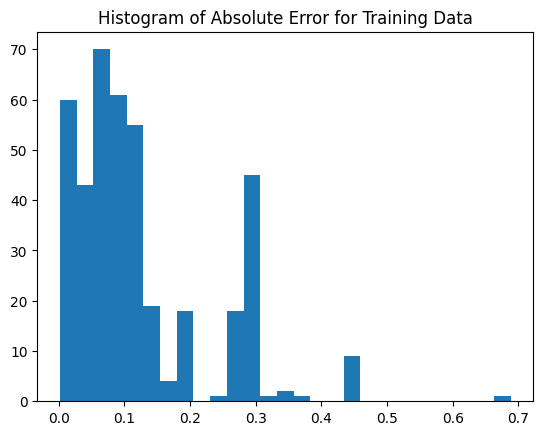

In [12]:
plt.hist(np.abs(np.array(train_loader_v) - np.array(train_infer_v)), bins='auto')
plt.title("Histogram of Absolute Error for Training Data")
plt.show()

### Test Data

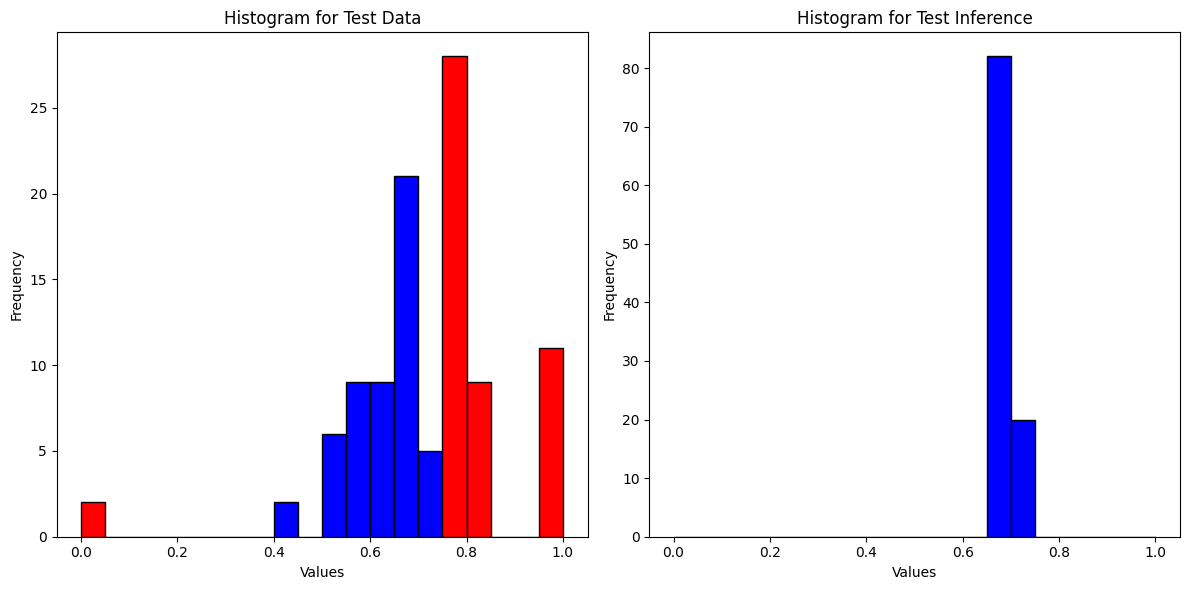

In [13]:
model.eval()

with torch.no_grad():
    test_loader_v = []
    test_infer_v = []
    for Phis, betas, vs, FDRs in test_loader:
        Phis, betas, vs, FDRs = Phis.to(device), betas.to(device), vs.to(device), FDRs.to(device)
        test_loader_v += FDRs.cpu().numpy().squeeze().tolist()
        test_infer_v += model(Phis, vs).detach().cpu().numpy().squeeze().tolist()

bin_edges = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(test_loader_v, bins=bin_edges, edgecolor='black')
ax1.set_title('Histogram for Test Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(test_infer_v, bins=bin_edges, edgecolor='black')
ax2.set_title('Histogram for Test Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

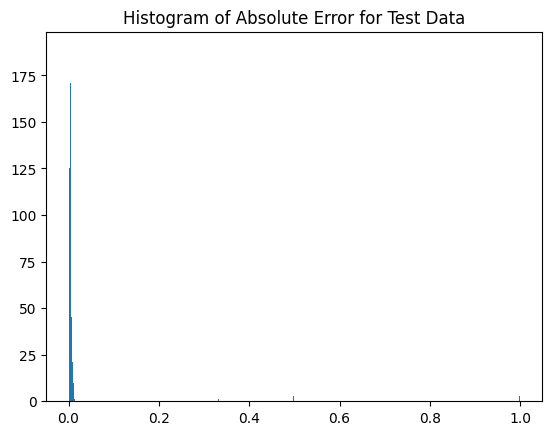

In [33]:
plt.hist(np.abs(np.array(test_loader_v) - np.array(test_infer_v)), bins='auto')
plt.title("Histogram of Absolute Error for Test Data")
plt.show()

## FDR and TPR

In [18]:
phi_dir = os.path.join(data_dir, 'Phi_mat')
true_actives_dir = os.path.join(data_dir, 'true_actives')
v_thresh_dir = os.path.join(data_dir, 'v_thresh')

phi_data = [np.loadtxt(os.path.join(phi_dir, f)) 
            for f in os.listdir(phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
true_actives_data = [np.loadtxt(os.path.join(true_actives_dir, f), dtype=int) - 1  # We substract 1 as they are R indices (starting from 1)
                     for f in os.listdir(true_actives_dir) if f.startswith('true_actives_') and f.endswith('.txt')]
v_thresh_data = [np.loadtxt(os.path.join(v_thresh_dir, f)) 
                            for f in os.listdir(v_thresh_dir) if f.startswith('v_thresh') and f.endswith('.txt')]

FDRs = []  # or FDPs
TPRs = []  # or TPPs
phi_dir = os.path.join(data_dir, 'Phi_mat')
true_actives_dir = os.path.join(data_dir, 'true_actives')
v_thresh_dir = os.path.join(data_dir, 'v_thresh')

phi_data = [np.loadtxt(os.path.join(phi_dir, f))
            for f in os.listdir(phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
true_actives_data = [np.loadtxt(os.path.join(true_actives_dir, f), dtype=int) - 1 # We substract 1 as they are R indices (starting from 1)
                     for f in os.listdir(true_actives_dir) if f.startswith('true_actives_') and f.endswith('.txt')]
v_thresh_data = [np.loadtxt(os.path.join(v_thresh_dir, f))
                 for f in os.listdir(v_thresh_dir) if f.startswith('v_thresh') and f.endswith('.txt')]

FDRs = []  # or FDPs
TPRs = []  # or TPPs
FDRs_opt = []  # or FDPs
TPRs_opt = []  # or TPPs
for phi, true_actives, v_thresh in zip(phi_data, true_actives_data, v_thresh_data):
    selected_opt = np.where(phi > v_thresh)[0]
    selected_actives_opt = np.intersect1d(selected_opt, true_actives, assume_unique=True)
    selected_null_opt = np.setdiff1d(selected_opt, selected_actives_opt, assume_unique=True)
    FDRs_opt.append(len(selected_null_opt) / max(len(selected_opt), 1))
    TPRs_opt.append(len(selected_actives_opt) / max(len(true_actives), 1))
    
    with torch.no_grad():   
        v = model(torch.Tensor(phi)).numpy()[0]
    selected = np.where(phi > v)[0]
    selected_actives = np.intersect1d(selected, true_actives, assume_unique=True)
    selected_null = np.setdiff1d(selected, selected_actives, assume_unique=True)
    FDRs.append(len(selected_null)/max(len(selected), 1))
    TPRs.append(len(selected_actives)/max(len(true_actives), 1))

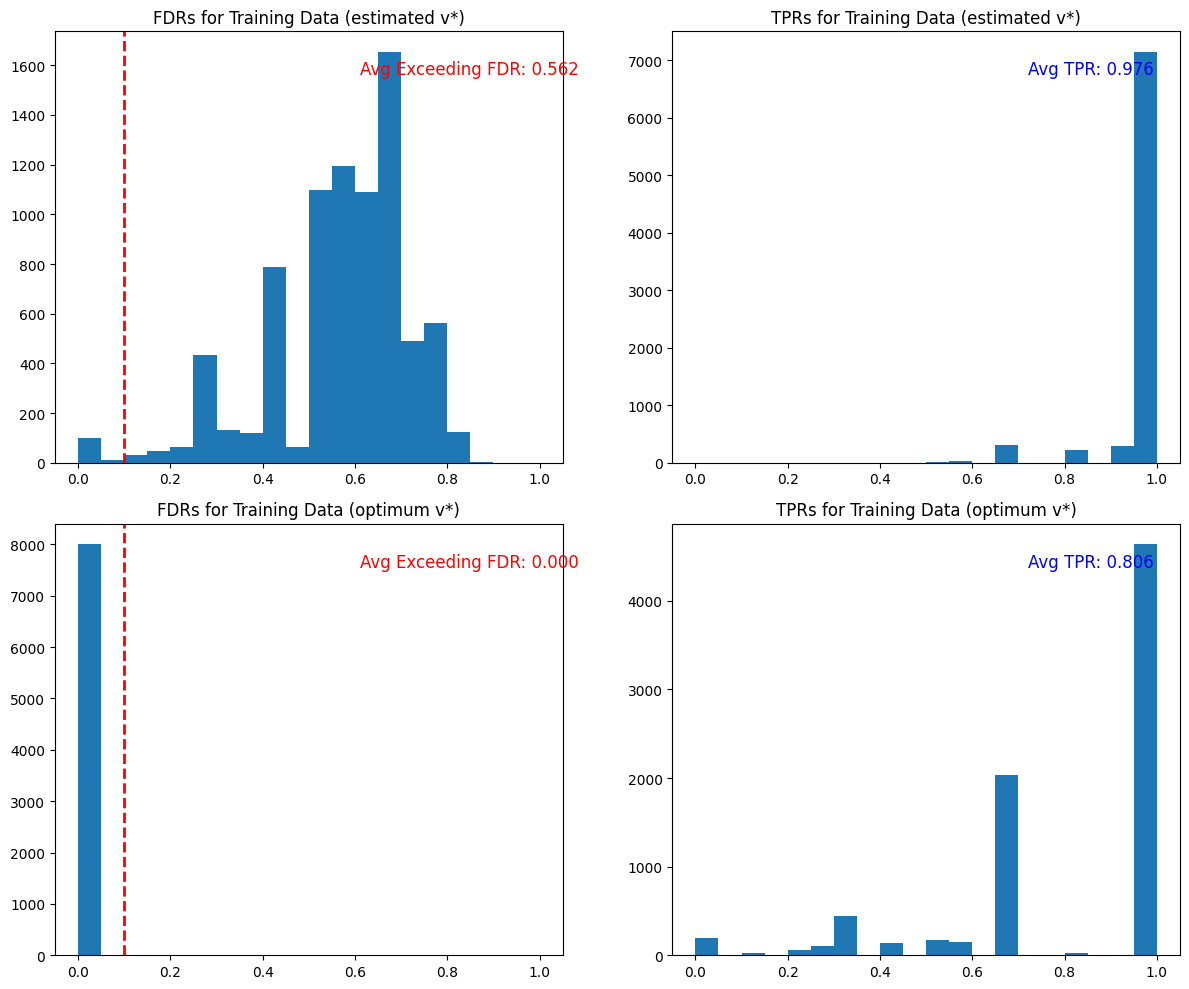

In [19]:
bins = np.arange(0, 1.05, 0.05)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

fdr_train = np.array(FDRs)[train_indices]
axs[0, 0].hist(fdr_train, bins=bins)
axs[0, 0].axvline(x=0.1, color='red', linestyle='--', linewidth=2)
axs[0, 0].set_title("FDRs for Training Data (estimated v*)")
exceeding_fdr_train = np.sum(fdr_train[fdr_train > 0.1])/len(fdr_train)
axs[0, 0].text(0.6, 0.9, f'Avg Exceeding FDR: {exceeding_fdr_train:.3f}', transform=axs[0, 0].transAxes, fontsize=12, color='red')

tpr_train = np.array(TPRs)[train_indices]
axs[0, 1].hist(tpr_train, bins=bins)
axs[0, 1].set_title("TPRs for Training Data (estimated v*)")
avg_tpr_train = np.mean(tpr_train)
axs[0, 1].text(0.7, 0.9, f'Avg TPR: {avg_tpr_train:.3f}', transform=axs[0, 1].transAxes, fontsize=12, color='blue')

fdr_opt_train = np.array(FDRs_opt)[train_indices]
axs[1, 0].hist(fdr_opt_train, bins=bins)
axs[1, 0].axvline(x=0.1, color='red', linestyle='--', linewidth=2)
axs[1, 0].set_title("FDRs for Training Data (optimum v*)")
exceeding_fdr_opt_train = np.sum(fdr_opt_train[fdr_opt_train > 0.1])/len(fdr_train)
axs[1, 0].text(0.6, 0.9, f'Avg Exceeding FDR: {exceeding_fdr_opt_train:.3f}', transform=axs[1, 0].transAxes, fontsize=12, color='red')

tpr_opt_train = np.array(TPRs_opt)[train_indices]
axs[1, 1].hist(tpr_opt_train, bins=bins)
axs[1, 1].set_title("TPRs for Training Data (optimum v*)")
avg_tpr_opt_train = np.mean(tpr_opt_train)
axs[1, 1].text(0.7, 0.9, f'Avg TPR: {avg_tpr_opt_train:.3f}', transform=axs[1, 1].transAxes, fontsize=12, color='blue')

plt.tight_layout()
plt.show()


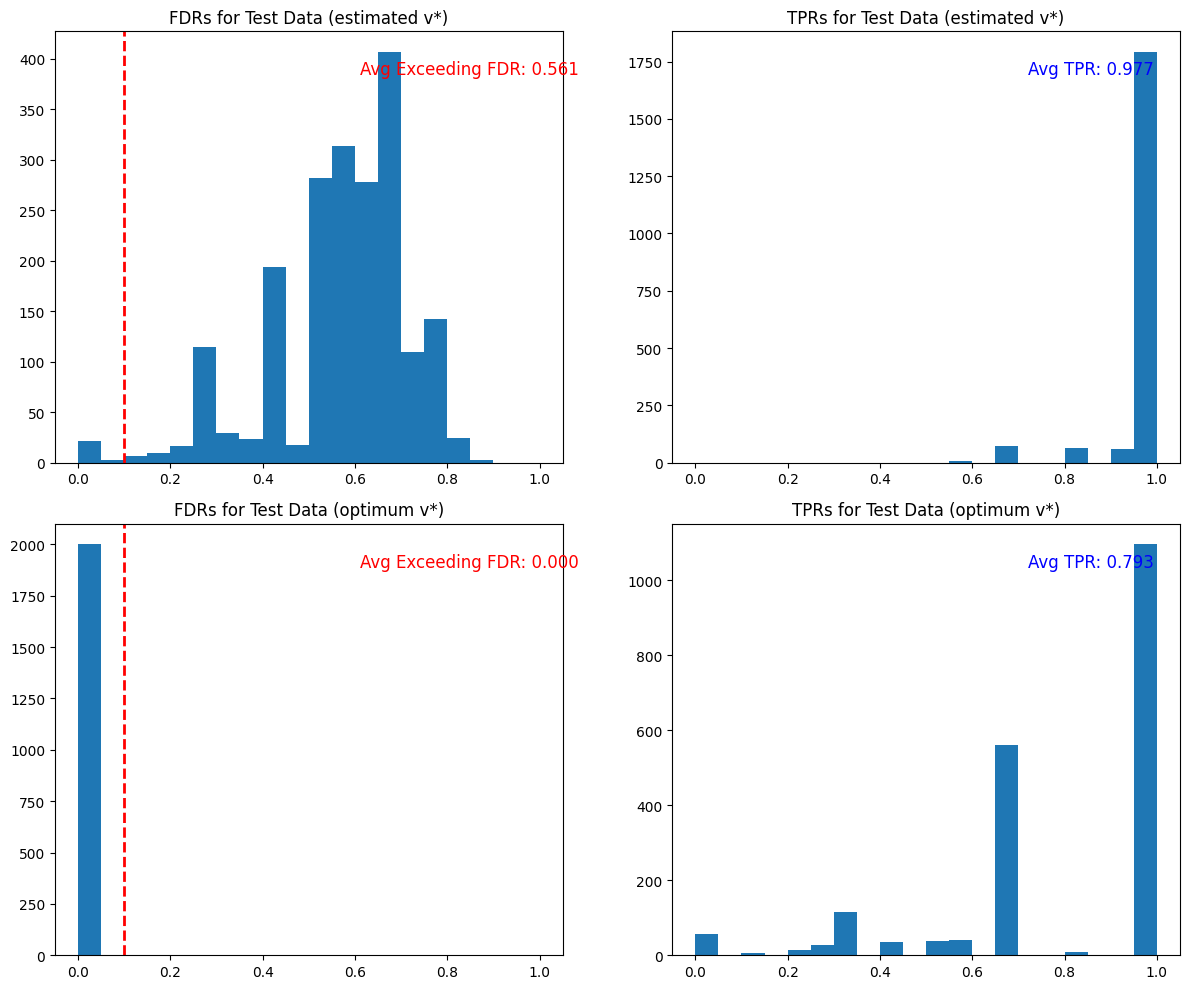

In [20]:
bins = np.arange(0, 1.05, 0.05)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

fdr_test = np.array(FDRs)[test_indices]
axs[0, 0].hist(fdr_test, bins=bins)
axs[0, 0].axvline(x=0.1, color='red', linestyle='--', linewidth=2)
axs[0, 0].set_title("FDRs for Test Data (estimated v*)")
exceeding_fdr_test = np.sum(fdr_test[fdr_test > 0.1])/len(fdr_test)
axs[0, 0].text(0.6, 0.9, f'Avg Exceeding FDR: {exceeding_fdr_test:.3f}', transform=axs[0, 0].transAxes, fontsize=12, color='red')

tpr_test = np.array(TPRs)[test_indices]
axs[0, 1].hist(tpr_test, bins=bins)
axs[0, 1].set_title("TPRs for Test Data (estimated v*)")
avg_tpr_test = np.mean(tpr_test)
axs[0, 1].text(0.7, 0.9, f'Avg TPR: {avg_tpr_test:.3f}', transform=axs[0, 1].transAxes, fontsize=12, color='blue')

fdr_opt_test = np.array(FDRs_opt)[test_indices]
axs[1, 0].hist(fdr_opt_test, bins=bins)
axs[1, 0].axvline(x=0.1, color='red', linestyle='--', linewidth=2)
axs[1, 0].set_title("FDRs for Test Data (optimum v*)")
exceeding_fdr_opt_test = np.sum(fdr_opt_test[fdr_opt_test > 0.1])/len(fdr_test)
axs[1, 0].text(0.6, 0.9, f'Avg Exceeding FDR: {exceeding_fdr_opt_test:.3f}', transform=axs[1, 0].transAxes, fontsize=12, color='red')

tpr_opt_test = np.array(TPRs_opt)[test_indices]
axs[1, 1].hist(tpr_opt_test, bins=bins)
axs[1, 1].set_title("TPRs for Test Data (optimum v*)")
avg_tpr_opt_test = np.mean(tpr_opt_test)
axs[1, 1].text(0.7, 0.9, f'Avg TPR: {avg_tpr_opt_test:.3f}', transform=axs[1, 1].transAxes, fontsize=12, color='blue')

plt.tight_layout()
plt.show()